Class names: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
Using Device : cuda
Epoch 1/25
Train Loss: 0.3058, Accuracy: 90.75%
Test Loss: 0.1574, Accuracy: 95.05%
----------
Epoch 2/25
Train Loss: 0.1525, Accuracy: 95.37%
Test Loss: 0.2134, Accuracy: 93.91%
----------
Epoch 3/25
Train Loss: 0.1169, Accuracy: 96.34%
Test Loss: 0.1790, Accuracy: 95.02%
----------
Epoch 4/25
Train Loss: 0.0818, Accuracy: 97.40%
Test Loss: 0.2205, Accuracy: 94.35%
----------
Epoch 5/25
Train Loss: 0.0867, Accuracy: 97.23%
Test Loss: 0.2373, Accuracy: 94.08%
----------
Epoch 6/25
Train Loss: 0.0768, Accuracy: 97.47%
Test Loss: 0.1991, Accuracy: 95.15%
----------
Epoch 7/25
Train Loss: 0.0651, Accuracy: 97.85%
Test Loss: 0.2161, Accuracy: 94.81%
----------
Epoch 8/25
Train Loss: 0.0493, Accuracy: 98.38%
Test Loss: 0.2291, Accuracy: 94.79%
----------
Epoch 9/25
Train Loss: 0.0560, Accuracy: 98.24%
Test Loss: 0.2106, Accuracy: 94.79%
----------
Epoch 10/25
Tr

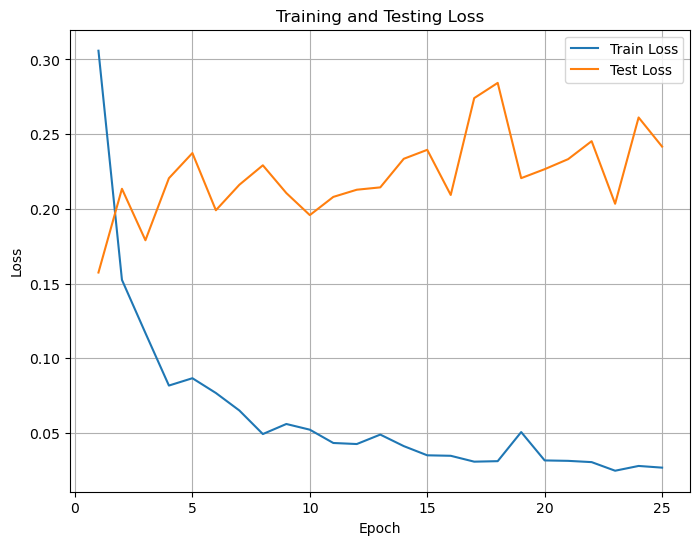

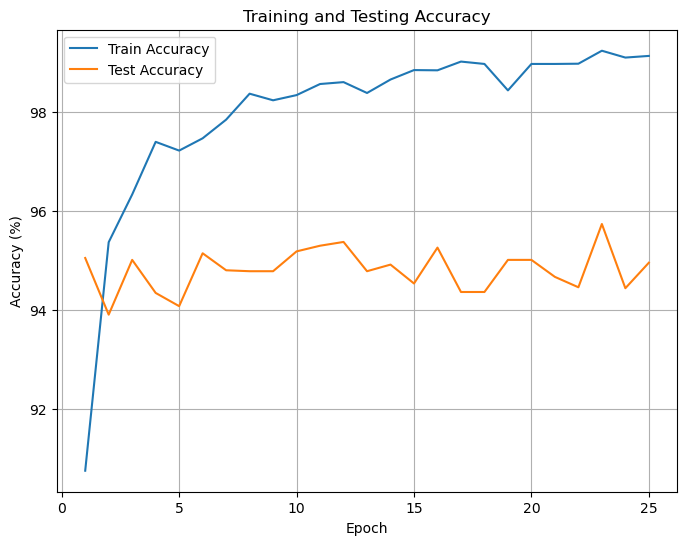

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 시드 설정 함수
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

#### 데이터 전처리 부분 ####

# 종 이름 번역 딕셔너리
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "ragno": "spider", "scoiattolo": "squirrel"
}

# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize([0.5177, 0.5003, 0.4126], [0.2135, 0.2130, 0.2151])  # 정규화
])

# 데이터셋 경로 설정
data_dir = r'G:\다운로드\archive\raw-img'

dataset = ImageFolder(root=data_dir, transform=transform)
# 클래스 이름 변경
dataset.classes = [translate[item] for item in dataset.classes]

# 데이터셋 인덱스 분할
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, stratify=dataset.targets, random_state=42)

# Subset 데이터셋 생성
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 클래스 이름 확인
class_names = dataset.classes
print("Class names:", class_names)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device : {device}")

# EfficientNet 모델 로드 및 수정
weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
model_ft = models.efficientnet_b0(weights=weights)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.001)

# 훈련 및 테스트 손실과 정확도를 저장할 리스트
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 훈련 함수
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(100. * correct / len(train_loader.dataset))
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {100. * correct / len(train_loader.dataset):.2f}%')

# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# 에포크 수 설정
num_epochs = 25

for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}/{num_epochs}')
    train(model_ft, train_loader, optimizer)
    test(model_ft, test_loader)
    print('-' * 10)

# 에포크에 따른 손실 함수 라인 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_testing_loss.png')
plt.show()

# 에포크에 따른 정확도 라인 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_testing_accuracy.png')
plt.show()


Class names: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
Using Device : cuda


Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to C:\Users\32184941/.cache\torch\hub\checkpoints\efficientnet_b1_rwightman-bac287d4.pth
100.0%


Epoch 1/25
Train Loss: 0.2632, Accuracy: 92.45%
Test Loss: 0.1515, Accuracy: 95.72%
----------
Epoch 2/25
Train Loss: 0.1236, Accuracy: 96.12%
Test Loss: 0.1590, Accuracy: 95.44%
----------
Epoch 3/25
Train Loss: 0.0874, Accuracy: 97.36%
Test Loss: 0.1694, Accuracy: 95.84%
----------
Epoch 4/25
Train Loss: 0.0744, Accuracy: 97.64%
Test Loss: 0.1840, Accuracy: 94.79%
----------
Epoch 5/25
Train Loss: 0.0676, Accuracy: 97.87%
Test Loss: 0.1856, Accuracy: 95.26%
----------
Epoch 6/25
Train Loss: 0.0506, Accuracy: 98.43%
Test Loss: 0.2048, Accuracy: 94.73%
----------
Epoch 7/25
Train Loss: 0.0508, Accuracy: 98.40%
Test Loss: 0.1966, Accuracy: 95.51%
----------
Epoch 8/25
Train Loss: 0.0511, Accuracy: 98.43%
Test Loss: 0.1798, Accuracy: 95.84%
----------
Epoch 9/25
Train Loss: 0.0462, Accuracy: 98.54%
Test Loss: 0.1781, Accuracy: 95.61%
----------
Epoch 10/25
Train Loss: 0.0445, Accuracy: 98.51%
Test Loss: 0.2294, Accuracy: 94.75%
----------
Epoch 11/25
Train Loss: 0.0357, Accuracy: 98.87%


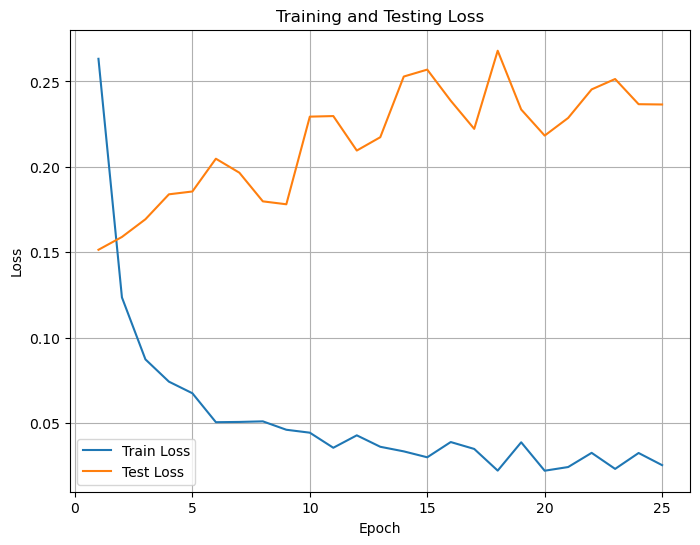

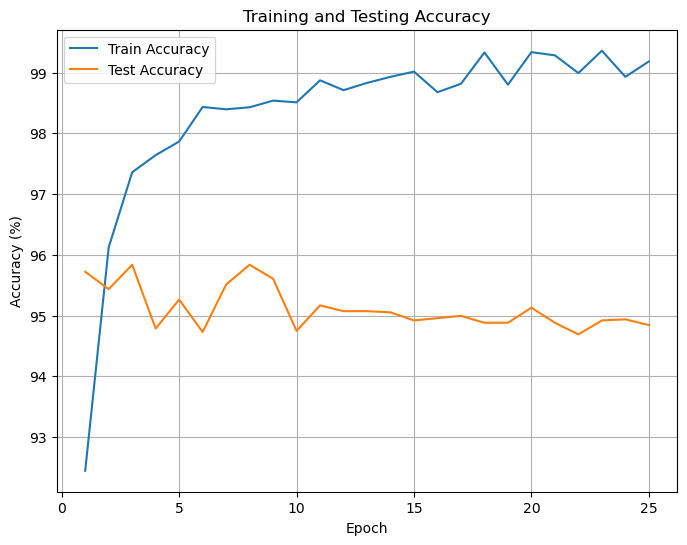

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 시드 설정 함수
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

#### 데이터 전처리 부분 ####

# 종 이름 번역 딕셔너리
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "ragno": "spider", "scoiattolo": "squirrel"
}

# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize([0.5177, 0.5003, 0.4126], [0.2135, 0.2130, 0.2151])  # 정규화
])

# 데이터셋 경로 설정
data_dir = r'G:\다운로드\archive\raw-img'

dataset = ImageFolder(root=data_dir, transform=transform)
# 클래스 이름 변경
dataset.classes = [translate[item] for item in dataset.classes]

# 데이터셋 인덱스 분할
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, stratify=dataset.targets, random_state=42)

# Subset 데이터셋 생성
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 클래스 이름 확인
class_names = dataset.classes
print("Class names:", class_names)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device : {device}")

# EfficientNet 모델 로드 및 수정
weights = models.EfficientNet_B1_Weights.IMAGENET1K_V1
model_ft = models.efficientnet_b1(weights=weights)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.001)

# 훈련 및 테스트 손실과 정확도를 저장할 리스트
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 훈련 함수
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(100. * correct / len(train_loader.dataset))
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {100. * correct / len(train_loader.dataset):.2f}%')

# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# 에포크 수 설정
num_epochs = 25

for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}/{num_epochs}')
    train(model_ft, train_loader, optimizer)
    test(model_ft, test_loader)
    print('-' * 10)

# 에포크에 따른 손실 함수 라인 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_testing_loss.png')
plt.show()

# 에포크에 따른 정확도 라인 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_testing_accuracy.png')
plt.show()


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\32184941/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth
0.7%

Class names: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
Using Device : cuda


100.0%


Epoch 1/25
Train Loss: 0.2951, Accuracy: 91.44%
Test Loss: 0.2050, Accuracy: 94.19%
----------
Epoch 2/25
Train Loss: 0.1526, Accuracy: 95.44%
Test Loss: 0.1684, Accuracy: 94.94%
----------
Epoch 3/25
Train Loss: 0.1097, Accuracy: 96.62%
Test Loss: 0.1541, Accuracy: 95.86%
----------
Epoch 4/25
Train Loss: 0.0855, Accuracy: 97.26%
Test Loss: 0.1935, Accuracy: 95.05%
----------
Epoch 5/25
Train Loss: 0.0852, Accuracy: 97.31%
Test Loss: 0.1781, Accuracy: 95.13%
----------
Epoch 6/25
Train Loss: 0.0694, Accuracy: 97.79%
Test Loss: 0.1884, Accuracy: 95.23%
----------
Epoch 7/25
Train Loss: 0.0545, Accuracy: 98.18%
Test Loss: 0.2160, Accuracy: 95.34%
----------
Epoch 8/25
Train Loss: 0.0544, Accuracy: 98.25%
Test Loss: 0.2094, Accuracy: 94.50%
----------
Epoch 9/25
Train Loss: 0.0455, Accuracy: 98.58%
Test Loss: 0.2029, Accuracy: 94.90%
----------
Epoch 10/25
Train Loss: 0.0576, Accuracy: 98.07%
Test Loss: 0.1849, Accuracy: 95.32%
----------
Epoch 11/25
Train Loss: 0.0442, Accuracy: 98.55%


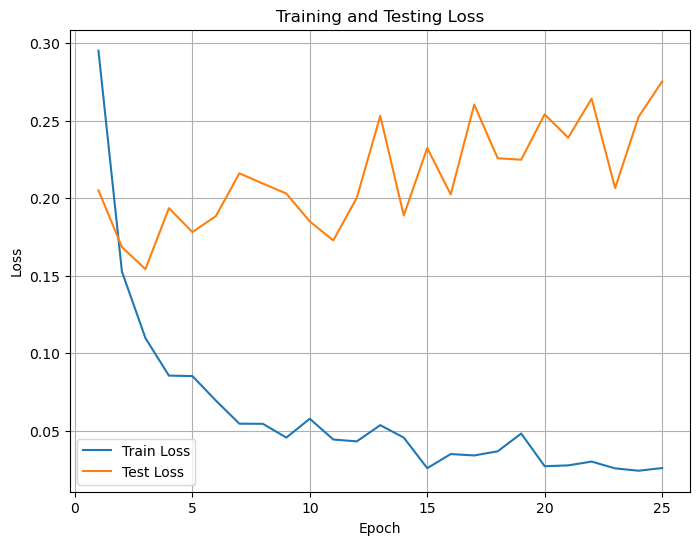

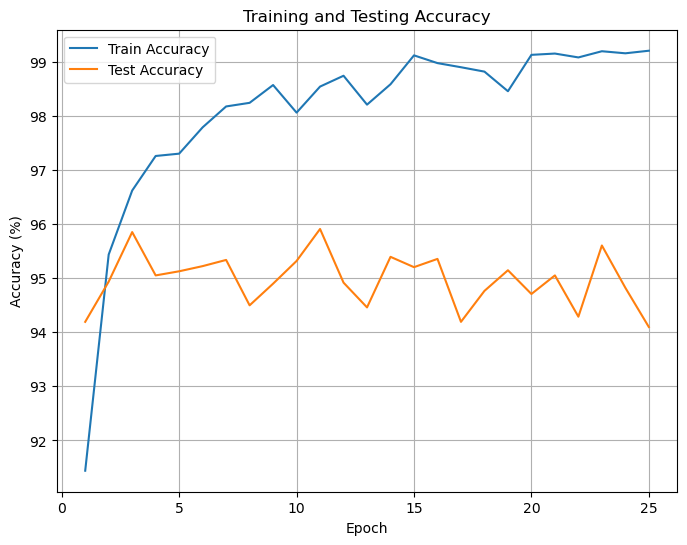

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 시드 설정 함수
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

#### 데이터 전처리 부분 ####

# 종 이름 번역 딕셔너리
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "ragno": "spider", "scoiattolo": "squirrel"
}

# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize([0.5177, 0.5003, 0.4126], [0.2135, 0.2130, 0.2151])  # 정규화
])

# 데이터셋 경로 설정
data_dir = r'G:\다운로드\archive\raw-img'

dataset = ImageFolder(root=data_dir, transform=transform)
# 클래스 이름 변경
dataset.classes = [translate[item] for item in dataset.classes]

# 데이터셋 인덱스 분할
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, stratify=dataset.targets, random_state=42)

# Subset 데이터셋 생성
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 클래스 이름 확인
class_names = dataset.classes
print("Class names:", class_names)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device : {device}")

# EfficientNet 모델 로드 및 수정
weights = models.EfficientNet_B2_Weights.IMAGENET1K_V1
model_ft = models.efficientnet_b2(weights=weights)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.001)

# 훈련 및 테스트 손실과 정확도를 저장할 리스트
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 훈련 함수
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(100. * correct / len(train_loader.dataset))
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {100. * correct / len(train_loader.dataset):.2f}%')

# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# 에포크 수 설정
num_epochs = 25

for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}/{num_epochs}')
    train(model_ft, train_loader, optimizer)
    test(model_ft, test_loader)
    print('-' * 10)

# 에포크에 따른 손실 함수 라인 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_testing_loss.png')
plt.show()

# 에포크에 따른 정확도 라인 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_testing_accuracy.png')
plt.show()


Class names: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
Using Device : cuda


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 80.0MB/s]


Epoch 1/25
Train Loss: 1.7743, Accuracy: 56.98%
Test Loss: 1.2947, Accuracy: 82.81%
----------
Epoch 2/25
Train Loss: 1.0142, Accuracy: 84.16%
Test Loss: 0.7255, Accuracy: 91.77%
----------
Epoch 3/25
Train Loss: 0.6192, Accuracy: 90.21%
Test Loss: 0.4487, Accuracy: 94.58%
----------
Epoch 4/25
Train Loss: 0.4301, Accuracy: 92.34%
Test Loss: 0.3233, Accuracy: 94.98%
----------
Epoch 5/25
Train Loss: 0.3386, Accuracy: 93.18%
Test Loss: 0.2585, Accuracy: 95.23%
----------
Epoch 6/25
Train Loss: 0.2801, Accuracy: 93.85%
Test Loss: 0.2219, Accuracy: 95.97%
----------
Epoch 7/25
Train Loss: 0.2483, Accuracy: 94.32%
Test Loss: 0.1910, Accuracy: 96.16%
----------
Epoch 8/25
Train Loss: 0.2195, Accuracy: 94.81%
Test Loss: 0.1729, Accuracy: 96.24%
----------
Epoch 9/25
Train Loss: 0.2011, Accuracy: 94.90%
Test Loss: 0.1631, Accuracy: 96.33%
----------
Epoch 10/25
Train Loss: 0.1890, Accuracy: 95.22%
Test Loss: 0.1480, Accuracy: 96.60%
----------
Epoch 11/25
Train Loss: 0.1736, Accuracy: 95.53%


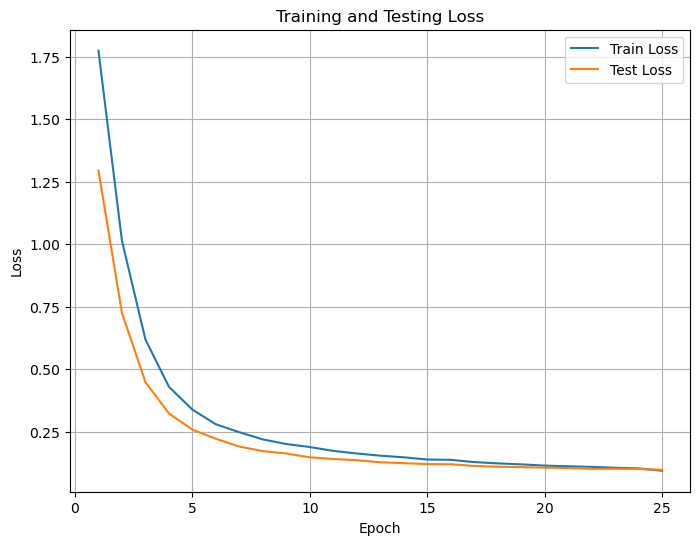

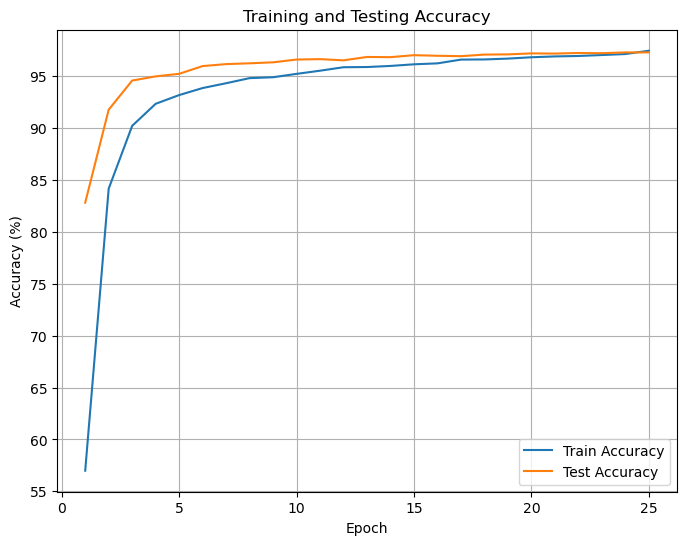

In [3]:
## SGD optimizer 적용 ##

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 시드 설정 함수
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

#### 데이터 전처리 부분 ####

# 종 이름 번역 딕셔너리
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "ragno": "spider", "scoiattolo": "squirrel"
}

# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize([0.5177, 0.5003, 0.4126], [0.2135, 0.2130, 0.2151])  # 정규화
])

# 데이터셋 경로 설정
data_dir = r'C:\Users\USER\Downloads\archive\raw-img'

dataset = ImageFolder(root=data_dir, transform=transform)
# 클래스 이름 변경
dataset.classes = [translate[item] for item in dataset.classes]

# 데이터셋 인덱스 분할
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, stratify=dataset.targets, random_state=42)

# Subset 데이터셋 생성
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 클래스 이름 확인
class_names = dataset.classes
print("Class names:", class_names)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device : {device}")

# EfficientNet 모델 로드 및 수정
weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
model_ft = models.efficientnet_b0(weights=weights)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.5)

# 훈련 및 테스트 손실과 정확도를 저장할 리스트
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 훈련 함수
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(100. * correct / len(train_loader.dataset))
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {100. * correct / len(train_loader.dataset):.2f}%')

# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# 에포크 수 설정
num_epochs = 25

for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}/{num_epochs}')
    train(model_ft, train_loader, optimizer)
    test(model_ft, test_loader)
    print('-' * 10)

# 에포크에 따른 손실 함수 라인 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_testing_loss.png')
plt.show()

# 에포크에 따른 정확도 라인 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_testing_accuracy.png')
plt.show()
